# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Rander metrics

In this notebook, we solve Rander eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and the GPU in the Rander case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, two dimensional only, whereas the GPU version uses a non-causal (yet monotone) Eulerian scheme, in two and three dimensions.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Constant metric](#1.1-Constant-metric)
    * [1.2 Zermelo's problem](#1.2-Zermelo's-problem)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

In [23]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 
anisotropy_bound = 20. if strong_anisotropy else 5. # Ratio between the fastest and the smallest velocity at any given point

## 1. Two dimensions

### 1.1 Constant metric

In [64]:
n=2000 if large_instances else 200
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1,
    'factoringRadius':20,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['metric'] = Metrics.Rander(cp.eye(2),cp.array([0.4,0.3]) )

In [26]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.01)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
#define Scalar_macro
typedef float Scalar;
#define Int_macro
typedef int Int;
#define OffsetT_macro
typedef int OffsetT;
#define pruning_macro false
#define shape_i_macro
const int shape_i[2] = {8,8};
#define niter_i_macro
const int niter_i=16;
#define multiprecision_macro false
#define factor_macro true
#define ndim_macro 2
#define drift_macro 1
#define geom_indep_macro 2
#define import_scheme_macro false
#define local_i_macro true
#define periodic_macro false
#define isotropic_macro false
#define walls_macro false
const int size_i = 64;
const int log2_size_i = 6;
#include "Riemann_.h"
// Date cuda code last modified : 1602748496.237121

Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.2234797477722168 seconds, and 252 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults 

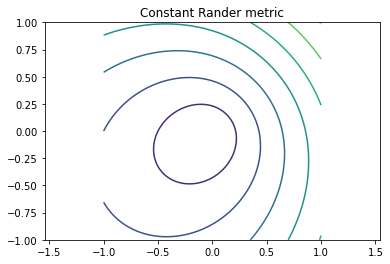

In [47]:
plt.title("Constant Rander metric"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

40401

### 1.2 Zermelo's problem

We obtain $\times 40$ speedup at resolution $2000\times 2000$ already. The lack of causality does not seem to be a significant issue for the GPU solver. The cost of the FM-ASR adaptive stencils cannot be neglected. 

In [120]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':12},'fim_front_width':8,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)

In [121]:
def Drift(x,mu):
    rho = (mu-1)/(mu+1)
    mult = rho*np.prod(np.sin(x),axis=0) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [122]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmIn.Grid(),mu=anisotropy_bound))

In [63]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.05);

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
#define Scalar_macro
typedef float Scalar;
#define Int_macro
typedef int Int;
#define OffsetT_macro
typedef int OffsetT;
#define pruning_macro false
#define shape_i_macro
const int shape_i[2] = {8,8};
#define niter_i_macro
const int niter_i=16;
#define multiprecision_macro false
#define ndim_macro 2
#define drift_macro 1
#define geom_indep_macro 0
#define import_scheme_macro false
#define local_i_macro true
#define periodic_macro false
#define isotropic_macro false
#define walls_macro false
const int size_i = 64;
const int log2_size_i = 6;
#include "Riemann_.h"
// Date cuda code last modified : 1602748496.237121

Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.7814748287200928 seconds, and 586 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencil

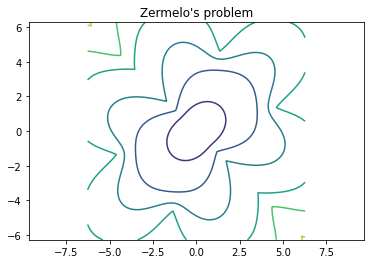

In [14]:
plt.title("Zermelo's problem"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

In [15]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for validation with multiple options
hfmInS.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
hfmInS.update({
    'metric' : Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmInS.Grid(),mu=anisotropy_bound)),
    'verbosity':0,
    'exportGeodesicFlow':True,
})

In [16]:
RunCompare(hfmInS,variants='basic',check=0.2)

Solver time (s). GPU : 0.02349853515625, CPU : 0.189. Device acceleration : 8.043054545454545
Max |gpuValues-cpuValues| :  0.17497255497242925

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.02199840545654297, CPU : 0.193. Device acceleration : 8.773363159491915
Max |gpuValues-cpuValues| :  0.1749654024150562

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.024463176727294922, CPU : 0.196. Device acceleration : 8.012042024832857
Max |gpuValues-cpuValues| :  0.16603189989324285

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.02849721908569336, CPU : 0.192. Device acceleration : 6.73749952311631
Max |gpuValues-cpuValues| :  0.1660247473358698


In [17]:
RunCompare(hfmInS,variants='ext',check=0.2)

Solver time (s). GPU : 0.019495010375976562, CPU : 0.194. Device acceleration : 9.951264259857156
Max |gpuValues-cpuValues| :  0.17497255497242925

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.02848196029663086, CPU : 0.193. Device acceleration : 6.776218981768261
Max |gpuValues-cpuValues| :  0.1749654024150562

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.023502588272094727, CPU : 0.189. Device acceleration : 8.041667488359353
Max |gpuValues-cpuValues| :  0.16603189989324285

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.024988412857055664, CPU : 0.195. Device acceleration : 7.803616864963887
Max |gpuValues-cpuValues| :  0.1660247473358698

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.020502090454101562, CPU : 0.195. Device acceleration : 9.511225230253977
Max |gpuValues-cpuValues| :  0.13339668794866277

 --- Variant {'factoringRadius': 10.0, 'factoring

## 2. Three dimensions

As mentioned in the introduction, the CPU variant does not handle three dimensional problems. We generalize here Zermelo's problem, for the sake of testing array broadcasting.

In [246]:
n = 200
hfmIn = Eikonal.dictIn({
    'model':'Rander3',
    'seed':[0.,0.,0.],
    'exportValues':1,
    'raiseOnNonConvergence':False,
#    'fim_front_width':8,'traits':{'niter_i':8}
})
side = [-2.*np.pi,2.*np.pi]
hfmIn.SetRect([side,side,side],dimx=n+1)

In [247]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(3),Drift(hfmIn.Grid(),mu=anisotropy_bound))

In [248]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
#define Scalar_macro
typedef float Scalar;
#define Int_macro
typedef int Int;
#define OffsetT_macro
typedef int OffsetT;
#define pruning_macro false
#define shape_i_macro
const int shape_i[3] = {4,4,4};
#define niter_i_macro
const int niter_i=8;
#define multiprecision_macro false
#define ndim_macro 3
#define drift_macro 1
#define fim_macro true
#define geom_indep_macro 0
#define import_scheme_macro false
#define local_i_macro true
#define periodic_macro false
#define isotropic_macro false
#define walls_macro false
const int size_i = 64;
const int log2_size_i = 6;
#include "Riemann_.h"
// Date cuda code last modified : 1602748496.237121

Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.34552431106567383 seconds, and 110 iterations.
Post-Processing
